# Feature Selection on the WHO Dataset

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from skmatter.preprocessing import StandardFlexibleScaler
from skmatter.feature_selection import PCovFPS, PCovCUR, FPS, CUR
from skmatter.datasets import load_who_dataset

## Load the Dataset

In [2]:
df = load_who_dataset()['data']
df

,Country,Year,SP.POP.TOTL,SH.TBS.INCD,SH.IMM.MEAS,SE.XPD.TOTL.GD.ZS,SH.DYN.AIDS.ZS,SP.DYN.LE00.IN,SH.IMM.IDPT,SH.XPD.CHEX.GD.ZS,SN.ITK.DEFC.ZS,NY.GDP.PCAP.CD
0,Afghanistan,2005,24411191.0,189.0,50.0,2.57000,0.1,58.361,58.0,9.948290,36.1,255.055120
1,Afghanistan,2006,25442944.0,189.0,53.0,2.90000,0.1,58.684,58.0,10.622766,33.3,274.000486
2,Afghanistan,2007,25903301.0,189.0,55.0,2.85000,0.1,59.111,63.0,9.904675,29.8,375.078128
3,Afghanistan,2008,26427199.0,189.0,59.0,3.51000,0.1,59.852,64.0,10.256495,26.5,387.849174
4,Afghanistan,2009,27385307.0,189.0,60.0,3.73000,0.1,60.364,63.0,9.818487,23.3,443.845151
...,...,...,...,...,...,...,...,...,...,...,...,...
2015,South Africa,2015,55876504.0,988.0,86.0,5.48285,18.2,63.950,85.0,8.790190,5.2,6204.929901
2016,South Africa,2016,56422274.0,805.0,84.0,5.44424,18.4,64.747,85.0,8.821429,5.4,5735.066787
2017,South Africa,2017,56641209.0,738.0,81.0,5.59867,18.5,65.402,84.0,8.722624,5.5,6734.475153
2018,South Africa,2018,57339635.0,677.0,81.0,5.64401,18.6,65.674,82.0,8.858297,5.7,7048.522211


In [3]:
columns = np.array([
    "SP.POP.TOTL",
    "SH.TBS.INCD",
    "SH.IMM.MEAS",
    "SE.XPD.TOTL.GD.ZS",
    "SH.DYN.AIDS.ZS",
    "SH.IMM.IDPT",
    "SH.XPD.CHEX.GD.ZS",
    "SN.ITK.DEFC.ZS",
    "NY.GDP.PCAP.CD",
])

column_names = np.array([
    "Population",
    "Tuberculosis",
    "Immunization, measles",
    "Educ. Expenditure",
    "HIV",
    "Immunization, DPT",
    "Health Expenditure",
    "Undernourishment",
    "GDP per capita",
])

columns = columns[[8, 4, 5, 6, 1, 0, 7, 3, 2]].tolist()
column_names = column_names[[8, 4, 5, 6, 1, 0, 7, 3, 2]].tolist()

In [4]:
X_raw = np.array(df[columns]) 

# We are taking the logarithm of the population and GDP to avoid extreme distributions
log_scaled = ['SP.POP.TOTL', 'NY.GDP.PCAP.CD']
for ls in log_scaled:
    print(X_raw[:, columns.index(ls)].min(), X_raw[:, columns.index(ls)].max())
    if ls in columns:
        X_raw[:, columns.index(ls)] = np.log10(
            X_raw[:, columns.index(ls)]
        )
y_raw = np.array(df["SP.DYN.LE00.IN"])  # [np.where(df['Year']==2000)[0]])
y_raw = y_raw.reshape(-1, 1)
X_raw.shape

149841.0 7742681934.0
110.460874721483 123678.70214327476


(2020, 9)

## Scale and Center the Features and Targets

In [5]:
x_scaler = StandardFlexibleScaler(column_wise=True)
X = x_scaler.fit_transform(X_raw)

y_scaler = StandardFlexibleScaler(column_wise=True)
y = y_scaler.fit_transform(y_raw)

n_components = 2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)

## Provide an estimated target for the feature selector

In [6]:
kernel_params = {"kernel": "rbf", "gamma": 0.08858667904100832}
krr = KernelRidge(alpha=0.006158482110660267, **kernel_params)

yp_train = krr.fit(X_train, y_train).predict(X_train)

## Compute the Selections for Each Selector Type

In [7]:
n_select = X.shape[1]

### PCov-CUR

In [8]:
pcur = PCovCUR(n_to_select=n_select, progress_bar=True, mixing=0.0)
pcur.fit(X_train, yp_train)

  0%|          | 0/9 [00:00<?, ?it/s]

PCovCUR(mixing=0.0, n_to_select=9, progress_bar=True)

### PCov-FPS

In [9]:
pfps = PCovFPS(n_to_select=n_select, progress_bar=True, mixing=0.0, initialize=pcur.selected_idx_[0])
pfps.fit(X_train, yp_train)

  0%|          | 0/8 [00:00<?, ?it/s]

PCovFPS(mixing=0.0, n_to_select=9, progress_bar=True)

### CUR

In [10]:
cur = CUR(n_to_select=n_select, progress_bar=True)
cur.fit(X_train, y_train)

  0%|          | 0/9 [00:00<?, ?it/s]

CUR(n_to_select=9, progress_bar=True)

### FPS

In [11]:
fps = FPS(n_to_select=n_select, progress_bar=True, initialize=cur.selected_idx_[0])
fps.fit(X_train, y_train)

  0%|          | 0/8 [00:00<?, ?it/s]

FPS(initialize=8, n_to_select=9, progress_bar=True)

### (For Comparison) Recurisive Feature Addition

In [12]:
class RecursiveFeatureAddition:
    def __init__(self, n_to_select):
        self.n_to_select = n_to_select
        self.selected_idx_ = np.zeros(n_to_select, dtype=int)
    def fit(self, X, y):
        remaining = np.arange(X.shape[1])
        for n in range(self.n_to_select):
            errors = np.zeros(len(remaining))
            for i, pp in enumerate(remaining):
                krr.fit(
                    X[:, [*self.selected_idx_[:n], pp]], y
                )
                errors[i] = krr.score(X[:, [*self.selected_idx_[:n], pp]], y)
            self.selected_idx_[n] = remaining[np.argmax(errors)]
            remaining = np.array(np.delete(remaining, np.argmax(errors)), dtype=int)
        return self
rfa = RecursiveFeatureAddition(n_select).fit(X_train, y_train)

## Plot our Results

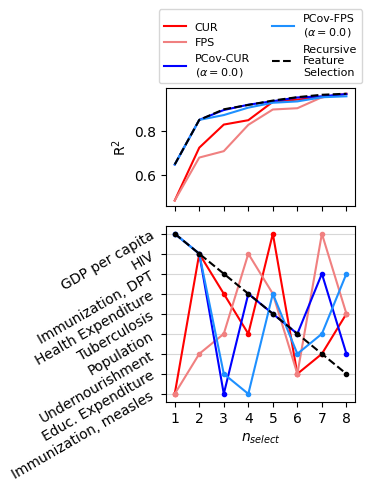

In [13]:
fig, axes = plt.subplots(2, 1,figsize=(3.75, 5), gridspec_kw=dict(height_ratios=(1,1.5)), sharex=True)
ns = np.arange(1, n_select, dtype=int)

all_errors = {}
for selector, color, linestyle, label in zip(
    [cur, fps, pcur, pfps, rfa],
    ["red", "lightcoral", "blue", "dodgerblue", "black"],
    ["solid", "solid", "solid", "solid", "dashed"],
    [
        "CUR",
        "FPS",
        "PCov-CUR\n"+r"($\alpha=0.0$)",
        "PCov-FPS\n"+r"($\alpha=0.0$)",
        "Recursive\nFeature\nSelection",
    ],  
):
    if label not in all_errors:
        errors = np.zeros(len(ns))
        for i, n in enumerate(ns):
            krr.fit(X_train[:, selector.selected_idx_[:n]], y_train)
            errors[i] = krr.score(X_test[:, selector.selected_idx_[:n]], y_test)
        all_errors[label] = errors
    axes[0].plot(ns, all_errors[label], c=color, label=label, linestyle=linestyle)
    axes[1].plot(ns, selector.selected_idx_[:max(ns)], c=color, marker='.', linestyle=linestyle)

axes[1].set_xlabel(r"$n_{select}$")
axes[1].set_xticks(range(1, n_select))
axes[0].set_ylabel(r"R$^2$")
axes[1].set_yticks(np.arange(X.shape[1]))
axes[1].set_yticklabels(column_names, rotation=30, fontsize=10)
axes[0].legend(ncol=2, fontsize=8, bbox_to_anchor=(0.5, 1.0), loc='lower center')
axes[1].invert_yaxis()
axes[1].grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig('who-selection.png', bbox_inches='tight')
plt.show()